In [1]:
%matplotlib notebook
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
import sigpy.plot as pl

from zte_recon.data_zte import Data_Arc_ZTE
from zte_recon.recon_gridding import recon_adjoint_postcomp_coilbycoil
from zte_recon.recon_l1_iter import recon_l1_wave_precond_coilbycoil
from zte_recon.util.sens import est_maps_3d
from zte_recon.bart_dims import coord_to_bart, ksp_to_bart
from zte_recon.arc_zte_traj import read_params_from_kacq
from zte_recon.plot import plot_coherence_pathways, plot_sphere, plot_3d_axes, plot_spokes_temporal_color

/home/shreya/cont-slew-zte/venv/lib/python3.10/site-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
libcudnn.so.8: cannot open shared object file: No such file or directory
  warnings.warn(


In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

os.environ["OMP_NUM_THREADS"] = "36"

In [3]:
seg_rot_file = '/home/shreya/cont-slew-zte/rot_txt_files/seg_golden3d_rotMats_large.txt'

# Shared acquisition parameters
points_per_spoke = 582
points_before_curve = 60
dt_sampling = 8
grad_dt_sampling = 4


# Reconstruction parameters
FOV_scale = 1
FOV_scale_dir = [1,1,1]
ndrop_ROpts = 1
img_shape = [256,256,256]

# Load acquired data

In [4]:
print('Loading data')

###############

### Small arc angle - 13 degrees
spoke_rot_file = None
grad_segment_file = '/mikBIG/shreya/cont_slew_zte_data/20250415/Series7/kacq_arc_zte.64999'
matlab_save_dir = '/mikBIG/shreya/cont_slew_zte_eval/20250415/Series7/'

params = read_params_from_kacq(grad_segment_file)
arc_angle = params['arc_angle']
a_grad = params['a_grad']

Data_angle13 = Data_Arc_ZTE(spoke_rot_file, seg_rot_file, arc_angle, points_per_spoke, 
                 points_before_curve, dt_sampling, grad_dt_sampling, a_grad, grad_segment_file,
                 matlab_save_dir, FOV_scale=FOV_scale, FOV_scale_dir=FOV_scale_dir, ndrop_ROpts=ndrop_ROpts)
Data_angle13.gradient_corr(-0.5)


################

### Intermediate arc angle - 53 degrees
spoke_rot_file = None
grad_segment_file = '/mikBIG/shreya/cont_slew_zte_data/20250415/Series11/kacq_arc_zte.90839'
matlab_save_dir = '/mikBIG/shreya/cont_slew_zte_eval/20250415/Series11/'

params = read_params_from_kacq(grad_segment_file)
arc_angle = params['arc_angle']
a_grad = params['a_grad']

Data_angle53 = Data_Arc_ZTE(spoke_rot_file, seg_rot_file, arc_angle, points_per_spoke, 
                 points_before_curve, dt_sampling, grad_dt_sampling, a_grad, grad_segment_file,
                 matlab_save_dir, FOV_scale=FOV_scale, FOV_scale_dir=FOV_scale_dir, ndrop_ROpts=ndrop_ROpts)
Data_angle53.gradient_corr(-0.5)

################

### Large arc angle - 83 degrees
spoke_rot_file = None
grad_segment_file = '/mikBIG/shreya/cont_slew_zte_data/20250415/Series14/kacq_arc_zte.27921'
matlab_save_dir = '/mikBIG/shreya/cont_slew_zte_eval/20250415/Series14/'

params = read_params_from_kacq(grad_segment_file)
arc_angle = params['arc_angle']
a_grad = params['a_grad']

Data_angle83 = Data_Arc_ZTE(spoke_rot_file, seg_rot_file, arc_angle, points_per_spoke, 
                 points_before_curve, dt_sampling, grad_dt_sampling, a_grad, grad_segment_file,
                 matlab_save_dir, FOV_scale=FOV_scale, FOV_scale_dir=FOV_scale_dir, ndrop_ROpts=ndrop_ROpts)
Data_angle83.gradient_corr(-0.5)

Loading data
Loading ksp from h5 dir: /mikBIG/shreya/cont_slew_zte_eval/20250415/Series7/
Setting nPtsPerSpoke to opxres 256
Applied gradient delay correction of -0.5
Loading ksp from h5 dir: /mikBIG/shreya/cont_slew_zte_eval/20250415/Series11/
Setting nPtsPerSpoke to opxres 256
Applied gradient delay correction of -0.5
Loading ksp from h5 dir: /mikBIG/shreya/cont_slew_zte_eval/20250415/Series14/
Setting nPtsPerSpoke to opxres 256
Applied gradient delay correction of -0.5


# Plot coherence pathways

In [74]:
def plot_coherence_pathways(DataObj, nSpokes_plot=20, spoke_start_idx=0, ylim=2):
    '''
    Coords dim [nSpokes, nPts, 3]
    '''
    # Initialize array to store kstronauts to plot
    kstronauts = np.empty((nSpokes_plot, 3, DataObj.nPtsPerSpoke))
    nPoints =  DataObj.nPtsPerSpoke
    
     # Normalize coords from DataObj
    coords_normalized = DataObj.coord_radial_spokes / (2*DataObj.coord_radial_spokes.max())

    for i in range(nSpokes_plot):
        
        # Get ith spoke
        spoke = coords_normalized[i+spoke_start_idx].transpose(1,0)
        kstronauts[i] = spoke
        
        # Plot all kstronaut from ith excitation
        if (i == 0):
            c = 'b'
            label='From TR #' + str(spoke_start_idx+1)
        elif (i == 1):
            c = 'c'
            label='From TR #' + str(spoke_start_idx+2)
        else:
            c = 'y'
            label=None
        plt.plot(np.arange(i*nPoints, (i+1)*nPoints, 1), np.linalg.norm(spoke, axis=0), c, label=label)

        # Plot all previous coherences evolving during same TR
        # Plot only 60 previous coherences, assuming complex T2* dephasing
        for j in np.arange(0, i):
            kstronauts[j] = spoke + kstronauts[j][:, -1][:, None] # update previous kstronauts
            label=None

            if (j == 0):
                c = 'b'

            elif (j == 1):
                c = 'c'

            else:
                c = 'y'
            plt.plot(np.arange(i*nPoints, (i+1)*nPoints, 1), np.linalg.norm(kstronauts[j], axis=0), c)


    plt.ylabel('Cycles/voxel')
    plt.xlabel('time')
    plt.ylim([0, ylim])
    plt.yticks([0, 0.5, 1, ylim])
    ax = plt.gca()
    
    ax.set_yticklabels(['0', '0.5', '1', str(ylim)])

    plt.tick_params(left = True, right = False , labelleft = True , 
                    labelbottom = False, bottom = False) 
    plt.legend(loc='upper right')
    plt.axhline(y=0.5, linestyle='--', c='r', alpha=0.75)
    plt.axhline(y=1, linestyle='--', c='darkgreen', alpha=1)

<IPython.core.display.Javascript object>


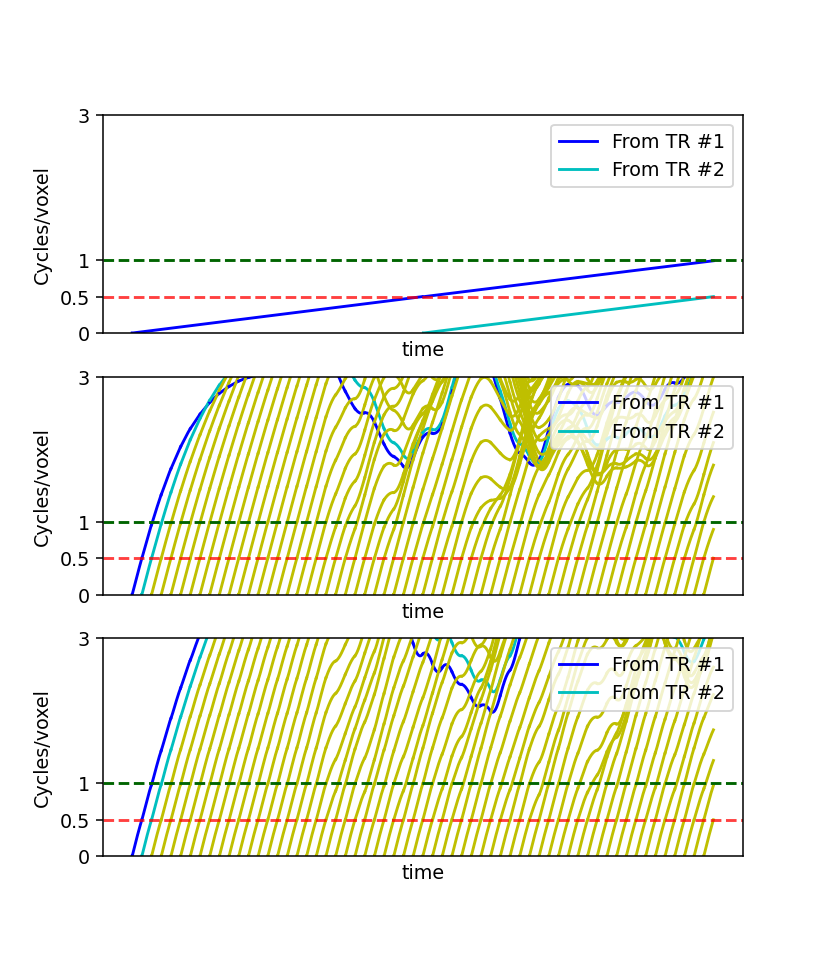

In [76]:
plt.figure(figsize=(6,7))
ax1 = plt.subplot(311)
plot_coherence_pathways(Data_angle13, nSpokes_plot=2, spoke_start_idx=0, ylim=3)

ax2 = plt.subplot(312)
plot_coherence_pathways(Data_angle53, nSpokes_plot=60, spoke_start_idx=0, ylim=3)

ax3 = plt.subplot(313)
plot_coherence_pathways(Data_angle83, nSpokes_plot=60, spoke_start_idx=0, ylim=3)

In [77]:
plt.savefig('saved_figures/coherences_0_legend.png', dpi=800)

<IPython.core.display.Javascript object>


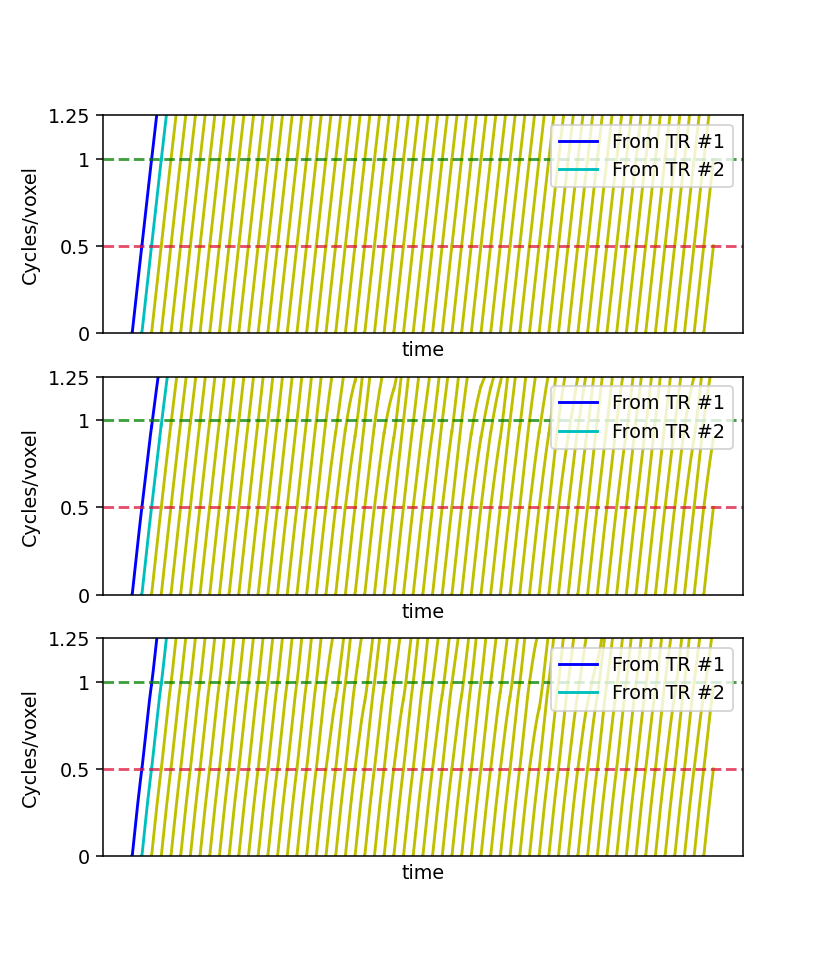

In [44]:
plt.figure(figsize=(6,7))
ax1 = plt.subplot(311)
plot_coherence_pathways(Data_angle13, nSpokes_plot=60, spoke_start_idx=0, ylim=1.25)

ax2 = plt.subplot(312)
plot_coherence_pathways(Data_angle53, nSpokes_plot=60, spoke_start_idx=0, ylim=1.25)

ax3 = plt.subplot(313)
plot_coherence_pathways(Data_angle83, nSpokes_plot=60, spoke_start_idx=0, ylim=1.25)

In [45]:
plt.savefig('saved_figures/coherences_zoom_in.png', dpi=800)

# Plot k-space spokes

In [74]:
azim = -102
elev = 8

In [106]:
plot_3d_axes()
ax = plt.gca()
plot_spokes_temporal_color(ax, Data_angle13.coord_radial_spokes, azim=azim, elev=elev)

<IPython.core.display.Javascript object>

In [44]:
plt.savefig('saved_figures/fig4_traj_angle13.png', dpi=500)

In [107]:
plot_3d_axes()
ax = plt.gca()
plot_spokes_temporal_color(ax, Data_angle53.coord_radial_spokes, azim=azim, elev=elev)

<IPython.core.display.Javascript object>

In [50]:
plt.savefig('saved_figures/fig4_traj_angle43.png', dpi=500)

In [108]:
plot_3d_axes()
ax = plt.gca()
plot_spokes_temporal_color(ax, Data_angle83.coord_radial_spokes, azim=azim, elev=elev)

<IPython.core.display.Javascript object>

In [52]:
plt.savefig('saved_figures/fig4_traj_angle83.png', dpi=500)

# Reconstruct data using gridding reconstruction

In [6]:
##############

# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Data_angle13.combine_waspiHires_flat()

# Gridding reconstruction
coil_ims_angle13 = recon_adjoint_postcomp_coilbycoil(ksp=ksp_hires_waspi, 
                                                           coord=coord_hires_waspi, 
                                                           img_shape=img_shape, 
                                                           oversamp=1.25, norm="ortho")

# RSS coil combination
im_angle13 = sp.rss(coil_ims_angle13, axes=0)

##############

# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Data_angle53.combine_waspiHires_flat()

# Gridding reconstruction
coil_ims_angle53 = recon_adjoint_postcomp_coilbycoil(ksp=ksp_hires_waspi, 
                                                           coord=coord_hires_waspi, 
                                                           img_shape=img_shape, 
                                                           oversamp=1.25, norm="ortho")

# RSS coil combination
im_angle53 = sp.rss(coil_ims_angle53, axes=0)

###############

# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Data_angle83.combine_waspiHires_flat()

# Gridding reconstruction
coil_ims_angle83 = recon_adjoint_postcomp_coilbycoil(ksp=ksp_hires_waspi, 
                                                           coord=coord_hires_waspi, 
                                                           img_shape=img_shape, 
                                                           oversamp=1.25, norm="ortho")

# RSS coil combination
im_angle83 = sp.rss(coil_ims_angle83, axes=0)

Coil-by-coil Gridding recon: 100%|███| 12/12 [00:16<00:00,  1.36s/it]


Coil-by-coil recon finished


Coil-by-coil Gridding recon: 100%|███| 12/12 [00:15<00:00,  1.27s/it]


Coil-by-coil recon finished


Coil-by-coil Gridding recon: 100%|███| 12/12 [00:16<00:00,  1.38s/it]


Coil-by-coil recon finished


<IPython.core.display.Javascript object>


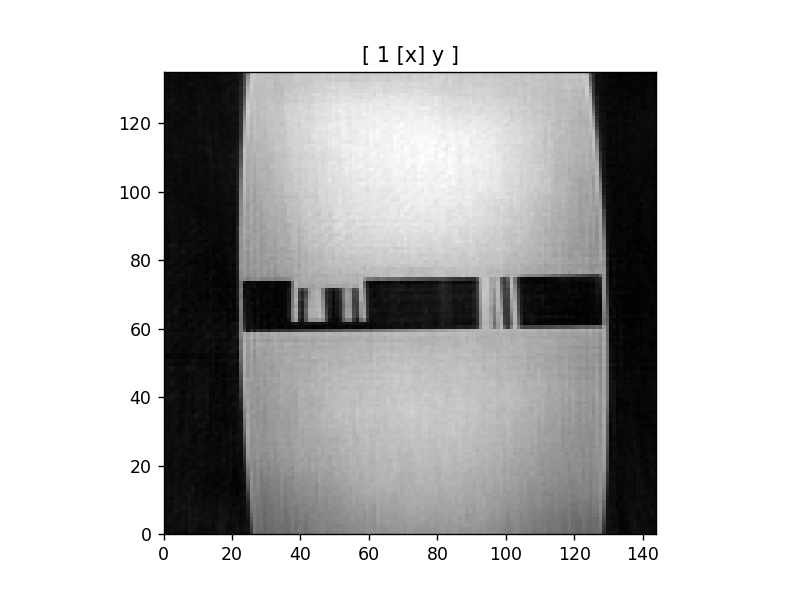

In [21]:
slice_num = 130
pl.ImagePlot(np.stack((im_angle13[56:200, slice_num, 75:210], 
                       im_angle53[56:200, slice_num, 75:210], 
                       im_angle83[56:200, slice_num, 75:210]), axis=0))

In [26]:
plt.savefig('saved_figures/fig4_recons_gridding_vert.png', dpi=800)

<IPython.core.display.Javascript object>


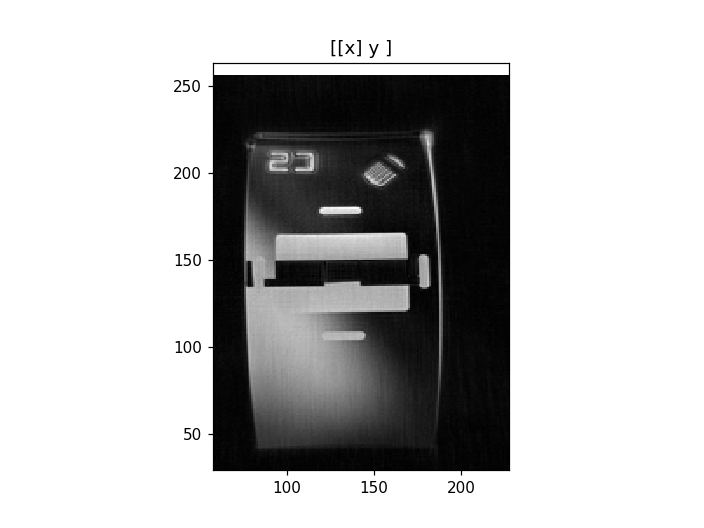

In [114]:
slice_num = 120
pl.ImagePlot(np.concatenate((im_angle83[:, slice_num], 
                       im_angle53[:, slice_num], 
                       im_angle13[:, slice_num]), axis=0))